# DDPM

Tiny Denoising Diffusion Probabilistic Model from scratch

<br/>

### Reference

https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing


In [1]:
import gc
import os
import math
import random

import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn

## Dataset

<br/>

Let's glance at our dataset.

In [2]:
def show_images(dataset, num_samples=20, cols=4):
  plt.figure(figsize=(15,15))

  samples = random.choices(range(0, len(dataset)), k=num_samples)

  for idx, sample in enumerate(samples):
    image, label = dataset[sample]
    plt.subplot(int(num_samples / cols), cols, idx + 1)
    plt.imshow(image)

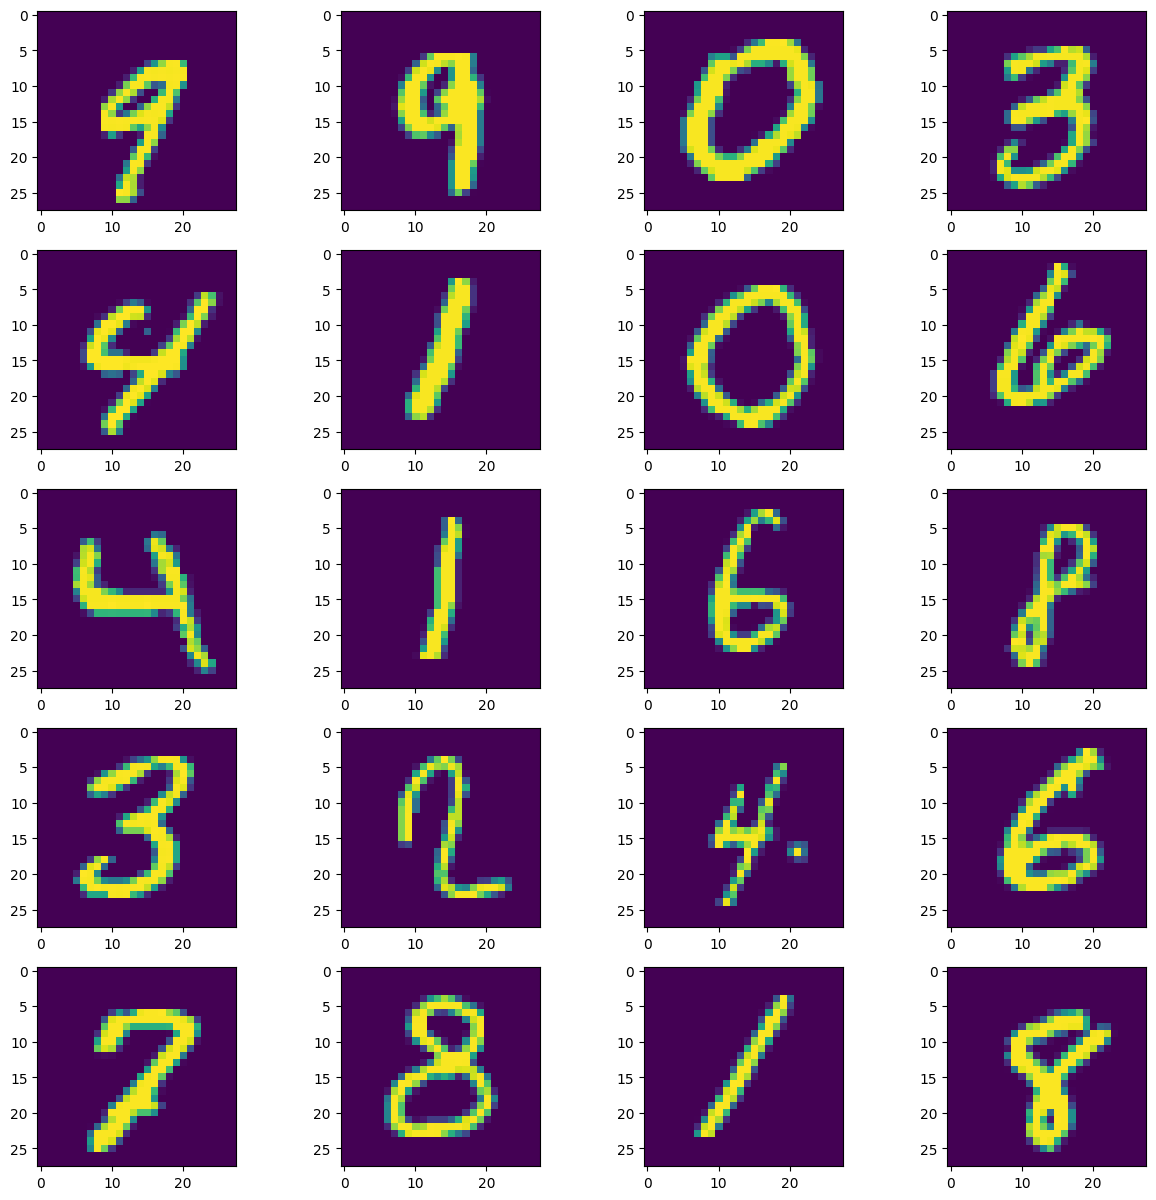

In [3]:
train_dataset = torchvision.datasets.MNIST(root='.', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='.', train=False, download=True)

dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

show_images(dataset)

In [4]:
print("Size of the dataset: ", len(dataset))

Size of the dataset:  70000


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: %s"%device)

device: cuda:0


In [6]:
torch.cuda.empty_cache()
gc.collect()

56838

## DataLoader

In [7]:
import numpy as np

from torchvision import transforms
from torch.utils.data import DataLoader

IMG_SIZE = 64
BATCH_SIZE = 256

In [8]:
def load_transformed_dataset():
  data_transforms = [
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(), # scaling to []
      transforms.Lambda(lambda t: t * 2 - 1) # scaling to [-1, 1]
  ]

  data_transforms = transforms.Compose(data_transforms)

  train_dataset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=data_transforms)
  test_dataset = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=data_transforms)

  dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

  return dataset

In [9]:
def show_tensor_image(img):
  reverse_transforms = [
      transforms.Lambda(lambda t: (t + 1) / 2.),
      transforms.Lambda(lambda t: t.permute(1, 2, 0)),
      transforms.Lambda(lambda t: t * 255.),
      transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
      transforms.ToPILImage()
  ]

  reverse_transforms = transforms.Compose(reverse_transforms)

  # show the first batch of image
  if len(img.shape) == 4:
    img = img[0, :, :, :]

  plt.imshow(reverse_transforms(img))

dataset = load_transformed_dataset()
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

## Utility

In [10]:
def linear_beta_schedule(time_steps, start=0.0001, end=0.02):
  return torch.linspace(start, end, time_steps)

In [11]:
def get_index_from_list(vals, t, x_shape):
  batch_size = t.shape[0]
  out = torch.gather(vals, -1, t.cpu())
  return out.reshape(batch_size, *((1, ) * (len(x_shape) - 1)))

## Overview of DDPM

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F7vlh1%2Fbtr8MrhMoKb%2FFtjNvuVsV06k6b1QWFpAxK%2Fimg.jpg"></img>

## Forward Process

<br/>

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fk7o3B%2Fbtr8LhtdlPu%2FPKRUCgj9uU2kJc9L8ZL2PK%2Fimg.jpg"></img>

In [12]:
T = 10
betas = linear_beta_schedule(T)
print(betas)

tensor([1.0000e-04, 2.3111e-03, 4.5222e-03, 6.7333e-03, 8.9444e-03, 1.1156e-02,
        1.3367e-02, 1.5578e-02, 1.7789e-02, 2.0000e-02])


<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FMlyih%2Fbtr8KKbs6w7%2FInhOy3NvD6Vf1o5lvIntg0%2Fimg.jpg"></img>

In [13]:
alphas = 1 - betas
print(alphas)

tensor([0.9999, 0.9977, 0.9955, 0.9933, 0.9911, 0.9888, 0.9866, 0.9844, 0.9822,
        0.9800])


In [14]:
alphas_cumprod = torch.cumprod(alphas, dim=-1)

print(alphas_cumprod)

tensor([0.9999, 0.9976, 0.9931, 0.9864, 0.9776, 0.9667, 0.9537, 0.9389, 0.9222,
        0.9037])


In [15]:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], pad=(1, 0), value=1.0)
print(alphas_cumprod_prev)

tensor([1.0000, 0.9999, 0.9976, 0.9931, 0.9864, 0.9776, 0.9667, 0.9537, 0.9389,
        0.9222])


<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FtkeHb%2Fbtr8KILpWxP%2FSsnxKMbxHychErW6G41FG0%2Fimg.jpg"></img>

In [16]:
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
print(sqrt_alphas_cumprod)

tensor([0.9999, 0.9988, 0.9965, 0.9932, 0.9887, 0.9832, 0.9766, 0.9690, 0.9603,
        0.9507])


In [17]:
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
print(sqrt_one_minus_alphas_cumprod)

tensor([0.0100, 0.0491, 0.0832, 0.1167, 0.1498, 0.1826, 0.2151, 0.2472, 0.2790,
        0.3103])


<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fod4b3%2Fbtr8KJp8vkD%2FnkyNbnlk5CAbIH7kVO9WH0%2Fimg.jpg"></img>

In [18]:
posterior_variances = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)
print(posterior_variances)

tensor([0.0000e+00, 9.5877e-05, 1.5750e-03, 3.4249e-03, 5.4264e-03, 7.5063e-03,
        9.6330e-03, 1.1791e-02, 1.3971e-02, 1.6168e-02])


<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FlhuOe%2Fbtr8XyUx4Si%2FpdIoZV7bvyJCZM4X07tkhK%2Fimg.jpg"></img>

In [19]:
inv_sqrt_alphas = torch.sqrt(1. / alphas)
print(inv_sqrt_alphas)

tensor([1.0000, 1.0012, 1.0023, 1.0034, 1.0045, 1.0056, 1.0068, 1.0079, 1.0090,
        1.0102])


<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FMlyih%2Fbtr8KKbs6w7%2FInhOy3NvD6Vf1o5lvIntg0%2Fimg.jpg"></img>

In [20]:
def forward_diffuse_sample(x_0, t, device="cpu"):
  # epsilon
  noise = torch.randn_like(x_0)
  sqrt_alphas_cumprod_t = get_index_from_list(
      sqrt_alphas_cumprod, t, x_0.shape
  )

  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, x_0.shape
  )

  x_t = sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

  return x_t.to(device), noise.to(device)  

<ipython-input-21-cc2e1292c3c9>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, int(i / step_size) + 1)


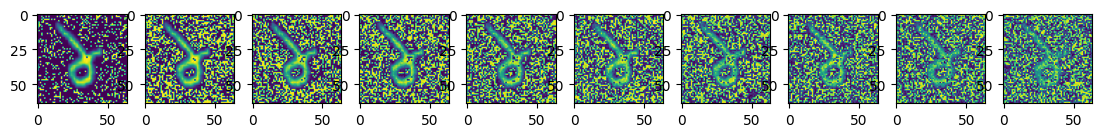

In [21]:
img = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')

num_images = 10
step_size = int(T / num_images)

for i in range(0, T, step_size):
  t = torch.Tensor([i]).type(torch.int64)
  plt.subplot(1, num_images + 1, int(i / step_size) + 1)
  x_t, noise = forward_diffuse_sample(img, t)
  show_tensor_image(x_t)  

## Backward Process (Denoising Process)

### U-net Architecture

In [22]:
class Block(nn.Module):
  def __init__(self, in_channel, out_channel, time_emb, up=False):
    super().__init__()

    # time conditioning
    self.mlp = nn.Linear(time_emb, out_channel)

    if up:
      # For residual connection
      self.conv1 = nn.Conv2d(2 * in_channel, out_channel, 3, padding=1)
      # Upsampling
      self.transform = nn.ConvTranspose2d(out_channel, out_channel, kernel_size=4, stride=2, padding=1)
    else:
      self.conv1 = nn.Conv2d(in_channel, out_channel, 3, padding=1)
      # Downsampling
      self.transform = nn.Conv2d(out_channel, out_channel, kernel_size=4, stride=2, padding=1)
    
    self.conv2 = nn.Conv2d(out_channel, out_channel, 3, padding=1)
    self.bnorm1 = nn.BatchNorm2d(out_channel)
    self.bnorm2 = nn.BatchNorm2d(out_channel)

    self.relu = nn.ReLU()

  def forward(self, x, t):
    # x = self.conv1(x)
    # x = self.relu(x)
    # h = self.bnorm1(x)
    h = self.bnorm1(self.relu(self.conv1(x)))
    time_emb = self.relu(self.mlp(t))
    time_emb = time_emb[..., None, None]
    
    h = h + time_emb
    h = self.bnorm2(self.relu(self.conv2(h)))

    return self.transform(h)

In [23]:
class PositionalEncoding(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, time):
    # shape of time: (batch_size, )
    device = time.device
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    
    return embeddings

In [24]:
class SimpleUnet(nn.Module):
  def __init__(self):
    super().__init__()
    img_channels = 1
    down_channels = (64, 128, 256, 512, 1024)
    up_channels = (1024, 512, 256, 128, 64)
    out_dim = 1
    time_emb_dim = 32

    self.pos_encoding = PositionalEncoding(time_emb_dim)
    self.linear = nn.Linear(time_emb_dim, time_emb_dim)
    self.relu = nn.ReLU()

    self.conv0 = nn.Conv2d(img_channels, down_channels[0], kernel_size=3, padding=1)
    
    self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(0, len(down_channels) - 1)])
    
    self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(0, len(up_channels) - 1)])
    
    self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

  def forward(self, x, time_step):
    t_emb = self.pos_encoding(time_step)
    t = self.relu(self.linear(t_emb))
    x = self.conv0(x)

    # For skip connections
    residual_outputs = []

    for down in self.downs:
      x = down(x, t)
      residual_outputs.append(x)

    for up in self.ups:
      residual_x = residual_outputs.pop()
      x = torch.cat((x, residual_x), dim=1)
      x = up(x, t)

    return self.output(x)

In [25]:
model = SimpleUnet()
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
model

Number of parameters:  62437601


SimpleUnet(
  (pos_encoding): PositionalEncoding()
  (linear): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 

## Loss

In [26]:
def get_loss(model, x_0, t):
  x_noisy, noise = forward_diffuse_sample(x_0, t, device)
  noise_pred = model(x_noisy, t)
  return F.l1_loss(noise, noise_pred)

## Sampling

In [27]:
@torch.no_grad()
def sample_timestep(x, t):
  betas_t = get_index_from_list(betas, t, x.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, x.shape
  )

  inv_sqrt_alphas_t = get_index_from_list(inv_sqrt_alphas, t, x.shape)
  
  model_mean = inv_sqrt_alphas_t * (
      x - betas_t * model(x.to(device), t.to(device)).detach().cpu() / sqrt_one_minus_alphas_cumprod_t
  )

  posterior_variances_t = get_index_from_list(posterior_variances, t, x.shape)

  if t == 0:
    return model_mean
  else:
    noise = torch.randn_like(x)

  return model_mean + torch.sqrt(posterior_variances_t) * noise

In [28]:
@torch.no_grad()
def sample_plot_image():
  img_size = IMG_SIZE
  img = torch.randn((1, 1, img_size, img_size))
  plt.figure(figsize=(15,15))
  plt.axis('off')
  num_images = 10

  step_size = int(T / num_images)

  for i in range(0, T, step_size):
    t = torch.full((1,), i, dtype=torch.long)
    img = sample_timestep(img, t)

    if i % step_size == 0:
      plt.subplot(1, num_images, int(i / step_size) + 1)
      show_tensor_image(img.detach().cpu())
    
  plt.show()

## Training

In [29]:
from torch.optim import Adam

model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)
epochs = 100

In [ ]:
for epoch in range(epochs):
  for step, batch in enumerate(dataloader):
    optimizer.zero_grad()

    # t sampling
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, batch[0], t)
    loss.backward()

    optimizer.step()

    if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} | Loss {loss.item()}")
      sample_plot_image()